<a href="https://colab.research.google.com/github/TivoGatto/Thesis/blob/master/Two%20Stage%20VAE/Two_Stage_VAE_MNIST_(fixed_gamma).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Dense, Flatten, Reshape, Conv2DTranspose, Lambda, Concatenate
from keras.datasets import mnist
import keras.backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
# Parameters
input_dim = (32, 32, 1)
latent_dim = 16

epochs = 150
batch_size = 100

initial_lr = 1e-4
halve_at_epoch = 100

beta = 0.2

TRAIN = False
SECOND_TRAIN = True

In [ ]:
# Functions
def vae_loss(z_mean, z_log_var):
    def loss(x_true, x_pred):
        x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
        x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

        L_rec = 0.5 * K.sum(K.square(x_true - x_pred), axis=-1)
        L_KL = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1)

        return K.mean(L_rec + beta * L_KL)
    return loss

def recon(x_true, x_pred):
    x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
    x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

    return K.mean(0.5 * K.sum(K.square(x_true - x_pred), axis=-1))

def KL(z_mean, z_log_var):
    def kl(x_true, x_pred):
        return K.mean(0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1))
    return kl

def sampling(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim)) # 100 = batch_size

    return z_mean + K.exp(0.5 * z_log_var) * eps

def pad(x, d):
    size = x.shape[0]
    h, w = x.shape[1:]

    x = np.reshape(x, (size, h, w, 1))

    x_padded = np.zeros(shape=(size, ) + d)
    x_padded[:, :h, :w] = x

    return x_padded

In [ ]:
# Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = pad(x_train, input_dim) / 255 # For MNIST, we pad x_train and x_test in 
x_test  = pad(x_test, input_dim) / 255 # shape (32, 32, 1)

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

print('x_train shape: ' + str(x_train.shape))
print('x_test shape: ' + str(x_test.shape))

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 32, 32, 1)
x_test shape: (10000, 32, 32, 1)


In [ ]:
# First stage VAE

# ENCODER
x = Input(shape=input_dim) # Shape (32, 32, 1)

h = Conv2D(32, 4, strides=(2, 2), padding='same')(x) # Shape (16, 16, 32)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(64, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 64)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(128, 4, strides=(2, 2), padding='same')(h) # Shape (4, 4, 128)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Flatten()(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_var])

encoder = Model(x, [z, z_mean, z_log_var])

# DECODER
z_in = Input(shape=(latent_dim, ))

h = Dense(4 * 4 * 128)(z_in)
h = Reshape((4, 4, 128))(h)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(128, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 128)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(64, 4, strides=(2, 2), padding='same')(h) # Shape (16, 16, 64)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(32, 4, strides=(2, 2), padding='same')(h) # Shape (32, 32, 32)
h = BatchNormalization()(h)
h = ReLU()(h)

x_decoded = Conv2DTranspose(1, 4, strides=(1, 1), padding='same', activation='sigmoid')(h) # Shape (32, 32, 1)

decoder = Model(z_in, x_decoded)

# VAE
x_recon = decoder(z)

vae = Model(x, x_recon)

# Compile model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
steps_per_epoch = 54000 / batch_size
lr_schedule = PiecewiseConstantDecay([steps_per_epoch * halve_at_epoch], [initial_lr, initial_lr/2])
optimizer = Adam(learning_rate=lr_schedule)

vae.compile(optimizer=optimizer, loss=vae_loss(z_mean, z_log_var), metrics=[recon, KL(z_mean, z_log_var)])

In [ ]:
if TRAIN:
    # Fit model
    hist = vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

# Save training history

In [ ]:
if TRAIN:
    loss = hist.history['loss']
    recon = hist.history['recon']
    kl = hist.history['kl']

    val_loss = hist.history['val_loss']
    val_recon = hist.history['val_recon']
    val_kl = hist.history['val_kl']

    from numpy import savetxt
    # save history
    data = np.asarray([loss, recon, kl, val_loss, val_recon, val_kl])
    savetxt('twostage_VAE_fixedgamma_MNIST.csv', data, delimiter=',')
    
    vae.save_weights('twostage_VAE_MNIST_fixedgamma.h5')
else:
    vae.load_weights('twostage_VAE_MNIST_fixedgamma.h5')

# Second stage

In [ ]:
# Second Stage VAE

# Loss
def second_stage_loss(u_mean, u_log_var):
    def loss(x_true, x_pred):
        L_rec = 0.5 * K.sum(K.square(x_true - x_pred), axis=-1)
        L_KL = 0.5 * K.sum(K.square(u_mean) + K.exp(u_log_var) - 1 - u_log_var, axis=-1)

        return K.mean(L_rec + 0.1 * L_KL)
    return loss

def second_stage_recon(x_true, x_pred):
    return K.mean(0.5 * K.sum(K.square(x_true - x_pred), axis=-1))

def second_stage_kl(u_mean, u_log_var):
    def second_kl(x_true, x_pred):
        return K.mean(0.5 * K.sum(K.square(u_mean) + K.exp(u_log_var) - 1 - u_log_var, axis=-1))
    return second_kl

def second_stage_sampling(args):
    u_mean, u_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_dim))

    return u_mean + eps * K.exp(0.5 * u_log_var)

# Encoder
intermediate_dim = 1024

z = Input(shape=(latent_dim, ))

h = Dense(intermediate_dim, activation='relu')(z)
h = Dense(intermediate_dim, activation='relu')(h)
h = Dense(intermediate_dim, activation='relu')(h)

h = Concatenate()([h, z])

u_mean = Dense(latent_dim)(h)
u_log_var = Dense(latent_dim)(h)

u = Lambda(second_stage_sampling)([u_mean, u_log_var])
second_encoder = Model(z, [u, u_mean, u_log_var])

# Decoder
u_in = Input(shape=(latent_dim, ))

h = Dense(intermediate_dim, activation='relu')(u_in)
h = Dense(intermediate_dim, activation='relu')(h)
h = Dense(intermediate_dim, activation='relu')(h)

h = Concatenate()([h, u_in])

z_decoded = Dense(latent_dim)(h)
second_decoder = Model(u_in, z_decoded)

# VAE
z_reconstructed = second_decoder(u)
second_vae = Model(z, z_reconstructed)

# Compile model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
steps_per_epoch = 60000 / batch_size
lr_schedule = PiecewiseConstantDecay([steps_per_epoch * halve_at_epoch], [initial_lr, initial_lr/2])
optimizer = Adam(learning_rate=lr_schedule)
second_vae.compile(optimizer=optimizer, loss=second_stage_loss(u_mean, u_log_var), metrics=[second_stage_recon, second_stage_kl(u_mean, u_log_var)])

In [ ]:
# Generate second stage Dataset
z_train = encoder.predict(x_train)[0]
z_test = encoder.predict(x_test)[0]

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [ ]:
if SECOND_TRAIN:
    # Fit second stage VAE
    second_vae.fit(z_train, z_train, batch_size=batch_size, epochs=epochs, verbose=1)
    
    second_vae.save_weights('second_twostage_VAE_MNIST_fixedgamma.h5')
else:
    second_vae.load_weights('second_twostage_VAE_MNIST_fixedgamma.h5')

Train on 60000 samples
Epoch 1/150
60000/60000 [==============================] - 2s 34us/sample - loss: 3.2976 - second_stage_recon: 1.6101 - second_kl: 16.8756
Epoch 2/150
60000/60000 [==============================] - 2s 34us/sample - loss: 2.7327 - second_stage_recon: 0.8985 - second_kl: 18.3414
Epoch 3/150
60000/60000 [==============================] - 2s 33us/sample - loss: 2.7186 - second_stage_recon: 0.8894 - second_kl: 18.2925
Epoch 4/150
60000/60000 [==============================] - 2s 33us/sample - loss: 2.7089 - second_stage_recon: 0.8829 - second_kl: 18.2601
Epoch 5/150
60000/60000 [==============================] - 2s 32us/sample - loss: 2.7003 - second_stage_recon: 0.8766 - second_kl: 18.2364
Epoch 6/150
60000/60000 [==============================] - 2s 32us/sample - loss: 2.6909 - second_stage_recon: 0.8696 - second_kl: 18.2129
Epoch 7/150
60000/60000 [==============================] - 2s 32us/sample - loss: 2.6865 - second_stage_recon: 0.8671 - second_kl: 18.1939
Epoc

# Generation and Reconstruction

Now we have two VAE network: \\
1) u <- p(u) = N(0, I) \\
2) z <- q(z) = E_p(u)[q(z|u)] \\
3) x <- p(x) = E_q(z)[p(x|z)] \\

And we can use them to generate new samples.

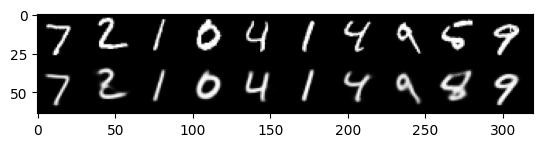

In [ ]:
# Reconstruction

"""
Here we don't need to use the second stage VAE, 'cause we don't use q(z)
"""
n = 10
digit_size = input_dim[0]

x_recon = vae.predict(x_test, batch_size=batch_size)
x_recon = np.reshape(x_recon, (-1, digit_size, digit_size))
x_test = np.reshape(x_test, (-1, digit_size, digit_size))
figure = np.zeros((2 * digit_size, n * digit_size))

for i in range(n):
    figure[:digit_size, i * digit_size: (i+1) * digit_size] = x_test[i]
    figure[digit_size:, i * digit_size: (i+1) * digit_size] = x_recon[i]

x_test = np.reshape(x_test, (-1, ) + input_dim)

plt.style.use('default')
plt.imshow(figure, cmap='gray')
plt.savefig('twostage_VAE_MNIST_fixedgamma_reconstruction.png')
plt.show()

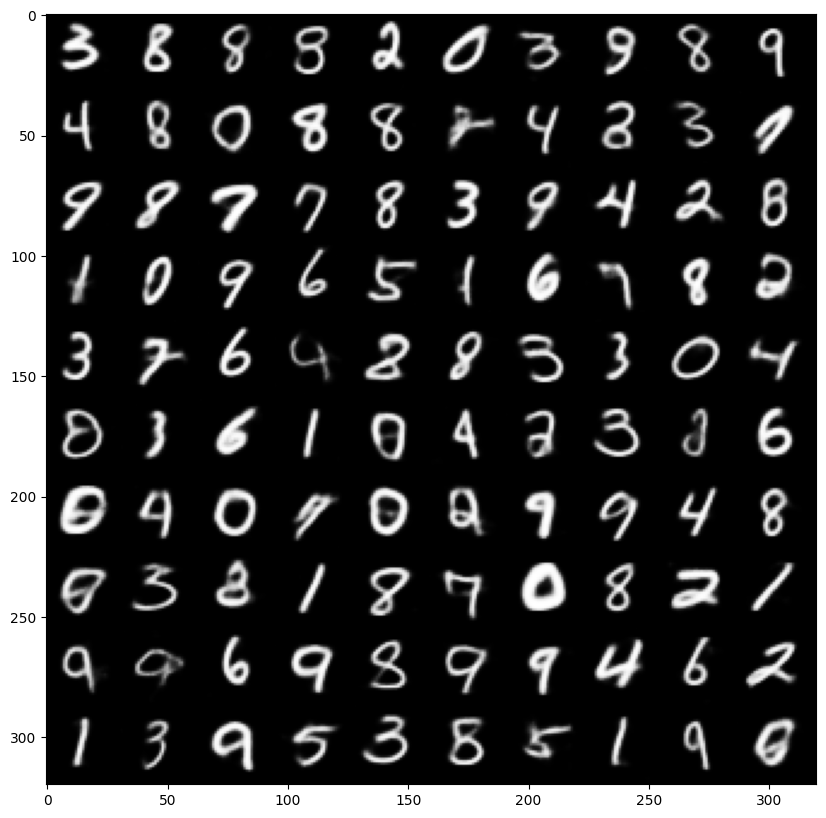

In [ ]:
# Generation
n = 10 #figure with n x n digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points randomly sampled

"""
We want to sample z from q(z) = E_p(u)[q(z|u)]
p(u) = N(0, I)
"""

u_sample = np.random.normal(size=(n**2, latent_dim), scale=1)
z_sample = second_decoder.predict(u_sample, batch_size=batch_size)
for i in range(n):
    for j in range(n):
        x_decoded = decoder.predict(np.array([z_sample[i + n * j]]))
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.savefig('twostage_VAE_MNIST_fixedgamma_generation.png')
plt.show()

# Interpolation

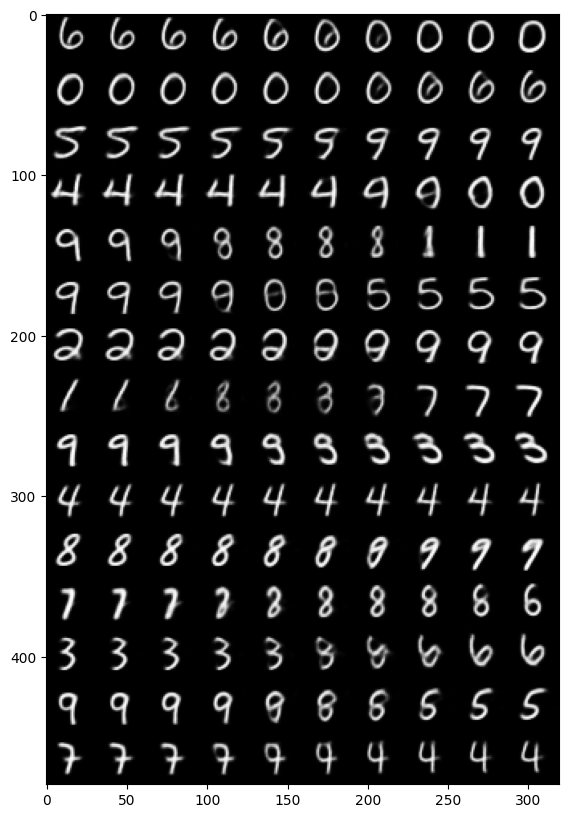

In [ ]:
T = 10
N = 15

s = 10
k = 100

X_final = [0] * N
for n in range(N):
    x_a = x_test[n + s]
    x_b = x_test[n + k]

    z_a = encoder.predict(np.reshape(x_a, (1, 32, 32, 1)))[0]
    z_b = encoder.predict(np.reshape(x_b, (1, 32, 32, 1)))[0]


    X = [0] * T
    for i in range(T):
        t = i/T
        z = t * z_a + (1 - t) * z_b

        X[i] = decoder.predict(z)
    
    X_final[n] = X

digit_size = 32
figure = np.zeros((N * digit_size, T * digit_size))
for n in range(N):
    for i in range(T):
        figure[n * digit_size : (n+1) * digit_size, i * digit_size : (i+1) * digit_size] = X_final[n][i][0, :, :, 0]

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.savefig('twostage_VAE_MNIST_fixedgamma_interpolation.png')
plt.show()

#Nearest Neighbour

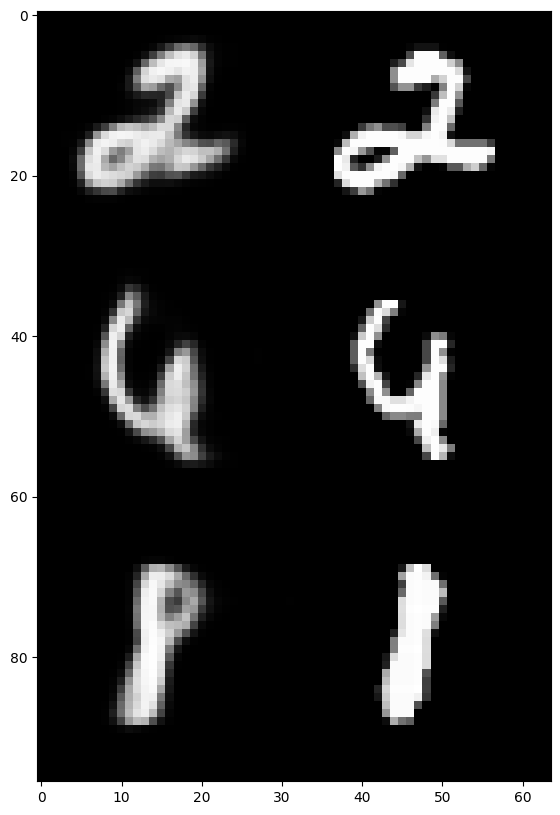

In [ ]:
# We want to investigate overfitting
def get_distance(x, y_vec):
    digit_size = x.shape[0]
    x = np.reshape(x, (digit_size**2, ))
    y_vec = np.reshape(y_vec, (-1, digit_size**2, ))

    res = np.zeros((y_vec.shape[0], ))
    for j in range(y_vec.shape[0]):
        res[j] = np.mean(np.square(x - y_vec[j]))

    return res

N = 3 # Images we need to check
digit_size = 32
u = np.random.normal(size=(N, latent_dim), scale=1)
z = second_decoder.predict(u, batch_size=batch_size)
x_gen = decoder.predict(z)
figure = np.zeros((N * digit_size, 2 * digit_size))
for i in range(N):
    x = x_gen[i]
    distances = get_distance(x, x_train)
    m = np.min(distances)
    i_m = np.argmin(distances)

    figure[i * digit_size : (i+1) * digit_size, : digit_size] = x[:, :, 0]
    figure[i * digit_size : (i+1) * digit_size, digit_size :] = x_train[i_m][:, :, 0]

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.savefig('twostage_VAE_MNIST_fixedgamma_NN.png')
plt.show()

# Metrics Evaluation

In [ ]:
import numpy as np
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
#from keras.applications.inception_v3 import preprocess_input
#from skimage.transform import resize
#from tensorflow.keras.models import load_model
#import os
#from matplotlib import pyplot

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    n_batches = inps.shape[0]//batch_size
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * batch_size:(i + 1) * batch_size]
        inpr = tf.image.resize(inp, (299, 299))
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr,steps=1)
        
        print('Processed ' + str((i+1) * batch_size) + ' images.')
    return act

def get_fid(images1, images2):
    print(images1.shape)
    print(images2.shape)
    print(type(images1))
    # calculate activations
    act1 = get_inception_activations(images1,batch_size=100)
    #print(np.shape(act1))
    act2 = get_inception_activations(images2,batch_size=100)
    # compute mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

u_sample = np.random.normal(0, 1, size=(x_test.shape[0], latent_dim))
z_sample = second_decoder.predict(u_sample)
x_gen = decoder.predict(z_sample)
x_gens = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))
x_tests = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))
for i in range(3):
	x_gens[:, :, :, i] = x_gen[:, :, :, 0]
	x_tests[:, :, :, i] = x_test[:, :, :, 0]

fid = get_fid(x_tests, x_gens)
print('\n FID: %.3f' % fid)

87916544/87910968 [==============================] - 1s 0us/step
(10000, 32, 32, 3)
(10000, 32, 32, 3)
<class 'numpy.ndarray'>
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 2100 images.
Processed 2200 images.
Processed 2300 images.
Processed 2400 images.
Processed 2500 images.
Processed 2600 images.
Processed 2700 images.
Processed 2800 images.
Processed 2900 images.
Processed 3000 images.
Processed 3100 images.
Processed 3200 images.
Processed 3300 images.
Processed 3400 images.
Processed 3500 images.
Processed 3600 images.
Processed 3700 images.
Processed 3800 images.
Processe

### Deactivated Latent Variables, Variance Loss and Variance Law


In [ ]:
def count_deactivated_variables(z_var, treshold = 0.8):
    z_var = np.mean(z_var, axis=0)

    return np.sum(z_var > treshold)

def loss_variance(x_true, x_recon):
    x_true = np.reshape(x_true, (-1, np.prod(x_true.shape[1:])))
    x_recon = np.reshape(x_recon, (-1, np.prod(x_recon.shape[1:])))

    var_true = np.mean(np.var(x_true, axis=1), axis=0)
    var_recon = np.mean(np.var(x_recon, axis=1), axis=0)

    return np.abs(var_true - var_recon)

########################################################################################################################
# SHOW THE RESULTS
########################################################################################################################

_, z_mean, z_log_var = encoder.predict(x_test, batch_size=batch_size)
z_var = np.exp(z_log_var)
n_deact = count_deactivated_variables(z_var)
print('We have a total of ', latent_dim, ' latent variables. ', count_deactivated_variables(z_var), ' of them are deactivated')

var_law = np.mean(np.var(z_mean, axis=0) + np.mean(z_var, axis=0))
print('Variance law has a value of: ', var_law)

x_recon = vae.predict(x_train, batch_size=batch_size)
print('We lost ', loss_variance(x_test, x_recon), 'Variance of the original data')

We have a total of  16  latent variables.  2  of them are deactivated
Variance law has a value of:  1.0032396
We lost  0.012311235 Variance of the original data


### Latent space matching

In [ ]:
# We want to verify if q(z) = p(z).

# Moments Matching
# Generate samples from q(z) and for p(z)
# p(z) = N(0, I)
# q(z) = E_q(x)[q(z|x)]
#
# For every moment we compare the moments
n = len(x_test)

u_samples = np.random.normal(size=(n, latent_dim))
p_samples = second_decoder.predict(u_samples)
q_samples = encoder.predict(x_test, batch_size=batch_size)[0]


from scipy.stats import moment
# First moment matching:
p_first_moment = np.mean(np.mean(p_samples, axis=0))
q_first_moment = np.mean(np.mean(q_samples, axis=0))

print("\n")
print("First moment of p(z): " + str(p_first_moment))
print("First moment of q(z): " + str(q_first_moment))
print("\n")

# Second moment matching:
p_second_moment = np.mean(np.var(p_samples, axis=0))
q_second_moment = np.mean(np.var(q_samples, axis=0))

print("\n")
print("Second moment of p(z): " + str(p_second_moment))
print("Second moment of q(z): " + str(q_second_moment))
print("\n")

# Thid moment matching:
p_third_moment = np.mean(moment(p_samples, moment=3, axis=0))
q_third_moment = np.mean(moment(q_samples, moment=3, axis=0))

print("\n")
print("Third moment of p(z): " + str(p_third_moment))
print("Third moment of q(z): " + str(q_third_moment))
print("\n")



First moment of p(z): -0.0020858422
First moment of q(z): -0.005231644




Second moment of p(z): 0.8694495
Second moment of q(z): 0.99959874




Third moment of p(z): 0.004277918
Third moment of q(z): 0.017124197




# MMD

In [ ]:
# To verify that q(z) = p(z) we can also use MMD

def compute_kernel(x, y):
    return np.exp(-np.mean(np.square(x - y), axis=-1))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

    return np.mean(x_kernel) + np.mean(y_kernel) - 2 * np.mean(xy_kernel) 

u_samples = np.random.normal(size=(len(x_test), latent_dim))
z_p = second_decoder.predict(u_samples) # sample from p(z)
z_q = encoder.predict(x_test, batch_size=batch_size)[0]  # sample from q(z)

z_p = z_p.astype('float32')
z_q = z_q.astype('float32')

mmd = compute_mmd(z_p, z_q)
print('MMD between p(z) and q(z) is ' + str(mmd))

MMD between p(z) and q(z) is 1.6353885531425476
